Your Best Entry 
Your submission scored 0.15307, which is an improvement of your previous score of 0.15986. Great job!

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard

# 1. Import libraries

In [1]:
from functions import *

# 2. Import and read data

In [2]:
get_list_of_zip_files(directory="C:\\Users\\KonuTech")[0:2]

['home-data-for-ml-course.zip',
 'house-prices-advanced-regression-techniques.zip']

In [3]:
unzip_files(directory="C:\\Users\\KonuTech"
            ,output_directory="C:\\Users\\KonuTech\\Downloads\\house-prices-advanced-regression-techniques"
            ,zip_file_name="house-prices-advanced-regression-techniques.zip")

Unpacked house-prices-advanced-regression-techniques.zip to: C:\Users\KonuTech\Downloads\house-prices-advanced-regression-techniques



In [4]:
change_current_working_directory(directory="C:\\Users\\KonuTech\\Downloads\\house-prices-advanced-regression-techniques")

'C:\\Users\\KonuTech\\Downloads\\house-prices-advanced-regression-techniques'

In [5]:
get_list_of_files_by_extension(directory="C:\\Users\\KonuTech\\Downloads\\house-prices-advanced-regression-techniques"
                               ,extension="csv")

['best_submission_gbr.csv',
 'sample_submission.csv',
 'submission.csv',
 'submission_forest.csv',
 'submission_gbr.csv',
 'submission_ridge.csv',
 'test.csv',
 'train.csv']

# 3. Data description

In [6]:
#f = open("data_description.txt", "r")
#print(f.read())

### Train data

In [7]:
train = pd.read_csv('train.csv')
train = train.drop(columns="Id", axis=1)
#train

In [8]:
train.shape

(1460, 80)

### Transformation of Int columns to Float columns

In [9]:
#train[train.select_dtypes(include=['int64']).columns] = train[train.select_dtypes(include=['int64']).columns].astype(float)
train[train.select_dtypes(include=['int64', "uint8"]).columns] = train[train.select_dtypes(include=['int64', "uint8"]).columns].astype(float)

# 4. Exploratory data analysis

# 4.1 Target variable

In [10]:
train['SalePrice'].describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64

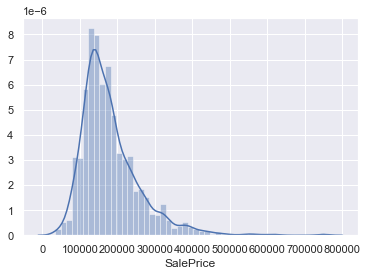

In [11]:
sns.distplot(train['SalePrice']);

In [12]:
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


### Test for Normality of Target

In [13]:
from scipy.stats import normaltest

In [14]:
stat, p = normaltest(train['SalePrice'])
print("stat=%.3f, p=%.3f\n" % (stat, p))
if p > 0.05:
    print("Probably Gaussian")
else:
    print("Probably not Gaussian")

stat=610.836, p=0.000

Probably not Gaussian


# 4.2 Predictor variables

### Initial correlations matrix

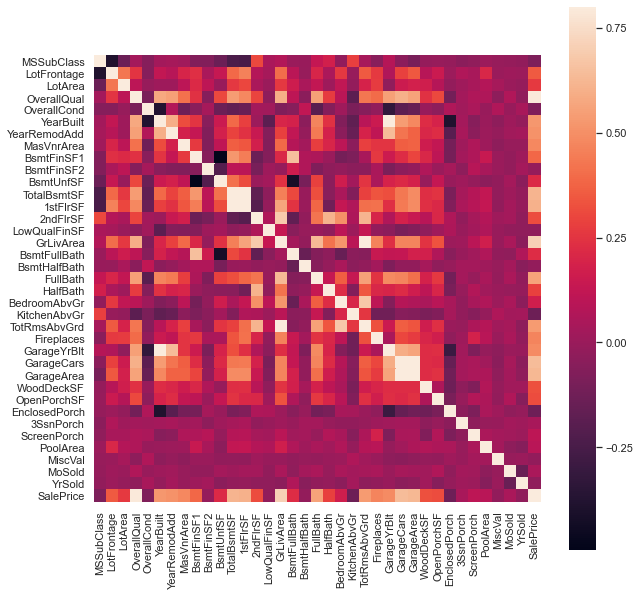

In [15]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmax=.8, square=True);

### Initial correlations against Target

In [16]:
corr_target = train[train.columns].corr()['SalePrice'][:-1]

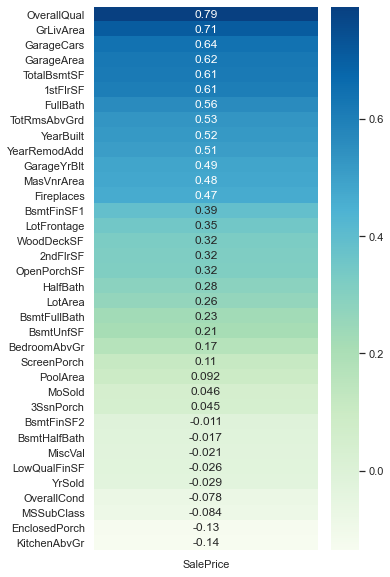

<Figure size 432x288 with 0 Axes>

In [17]:
plt.subplots(figsize=(5,10))
sns_plot = sns.heatmap(corr_target.sort_values(ascending=False).to_frame(),annot=True, annot_kws={'size':12},cmap="GnBu")
plt.show()
fig = sns_plot.get_figure()
fig.savefig("corr_target.jpg")
plt.clf()

### Initial pairplot

In [18]:
correlated_columns = pd.DataFrame(corr_target.sort_values(ascending=False)[0:5]).T.columns
correlated_columns

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF'], dtype='object')

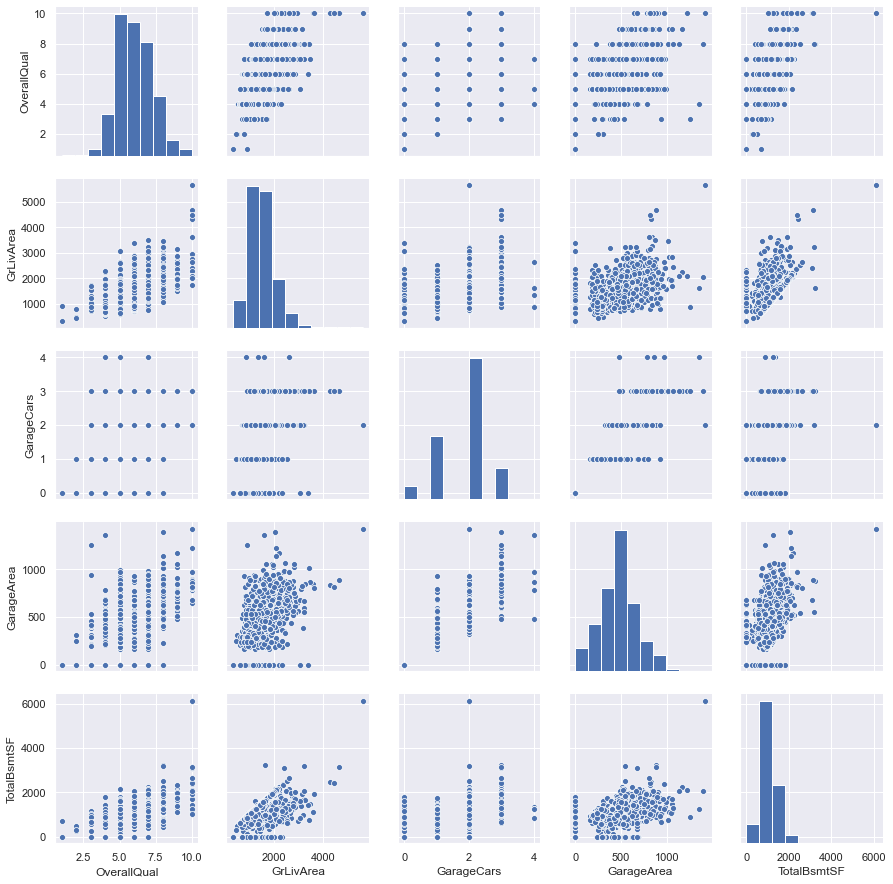

In [19]:
sns.set()
sns.pairplot(train[correlated_columns], size = 2.5)
plt.show();

### Target vs most correlated variable "OverallQual"

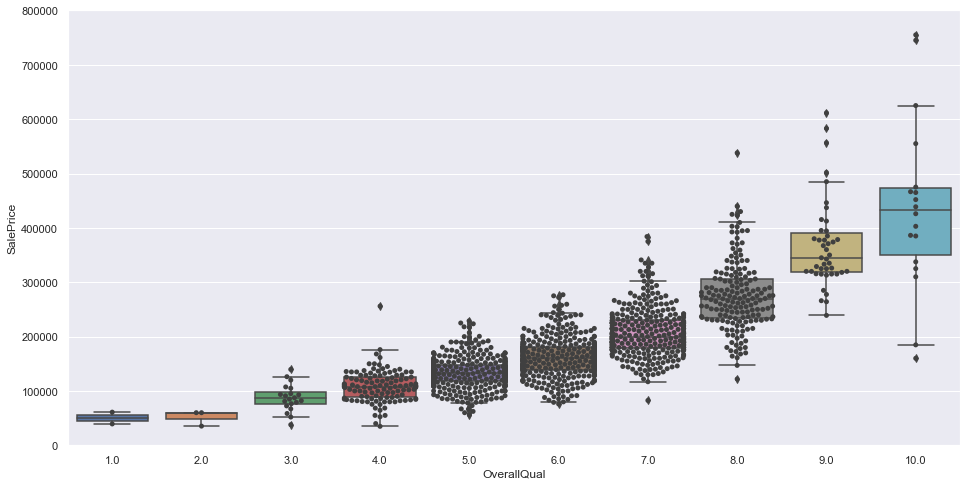

In [20]:
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x="OverallQual", y="SalePrice", data=train)
fig = sns.swarmplot(x='OverallQual', y="SalePrice", data=train, color=".25")
fig.axis(ymin=0, ymax=800000);

# 5. Dealing with NULL values

### Number of columns with Null values

In [21]:
(train.isnull().sum() > 0).sum()

19

### Summary statistics of mising data

### Counts

In [22]:
missing_data_count = pd.DataFrame(train.isnull().sum().sort_values(ascending=False))
#missing_data_count.T

In [23]:
#round(missing_data_count[missing_data_count > 0].describe(),3).T

#### Percetages

In [24]:
missing_data_percentage = pd.DataFrame(((train.isnull().sum().sort_values(ascending=False))/train.shape[0]))
#missing_data_percentage.T

In [25]:
#round(missing_data_percentage[missing_data_percentage > 0].describe(),3).T

# 5.1 Floats columns imputation

### Find float columns with missing values

In [26]:
floats_with_nulls = pd.DataFrame(train.select_dtypes(include=['float64']).isnull().sum()) > 0
floats_with_nulls = floats_with_nulls[floats_with_nulls[0] == True].T.columns
floats_with_nulls

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

### Print counts of unique values including Null values before imputation

In [27]:
count_unique_values(dataframe=train
                    ,variables=floats_with_nulls)

LotFrontage count distinct:
60.0     143
70.0      70
80.0      69
50.0      57
75.0      53
        ... 
38.0       1
138.0      1
140.0      1
137.0      1
nan      259
Length: 111, dtype: int64

MasVnrArea count distinct:
0.0      861
72.0       8
180.0      8
108.0      8
120.0      7
        ... 
337.0      1
415.0      1
293.0      1
621.0      1
nan        8
Length: 328, dtype: int64

GarageYrBlt count distinct:
2005.0    65
2006.0    59
2004.0    53
2003.0    50
2007.0    49
          ..
1927.0     1
1933.0     1
1900.0     1
1906.0     1
nan       81
Length: 98, dtype: int64



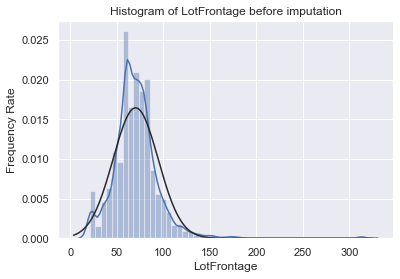

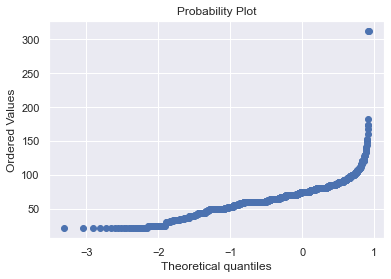

<Figure size 432x288 with 0 Axes>

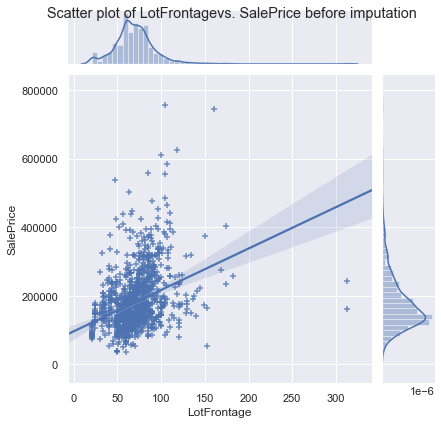

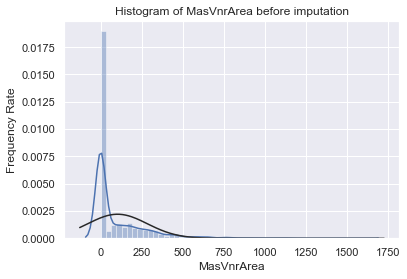

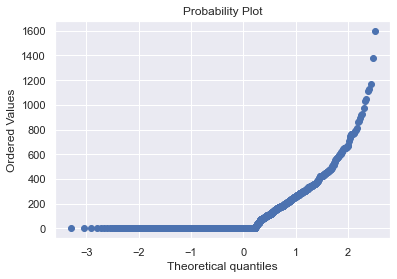

<Figure size 432x288 with 0 Axes>

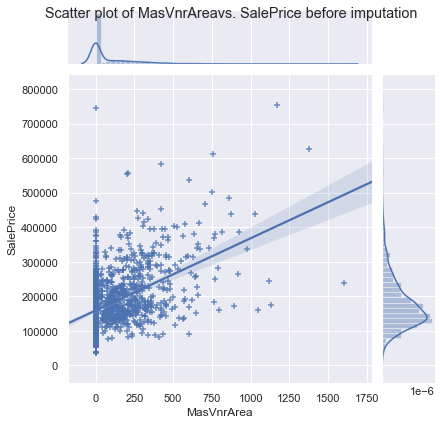

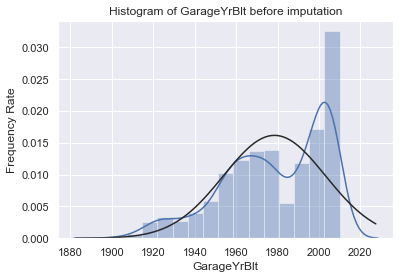

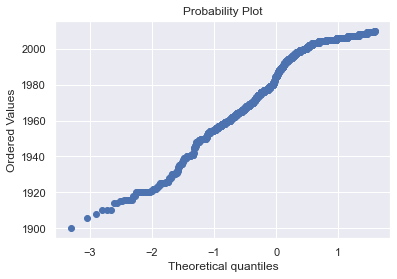

<Figure size 432x288 with 0 Axes>

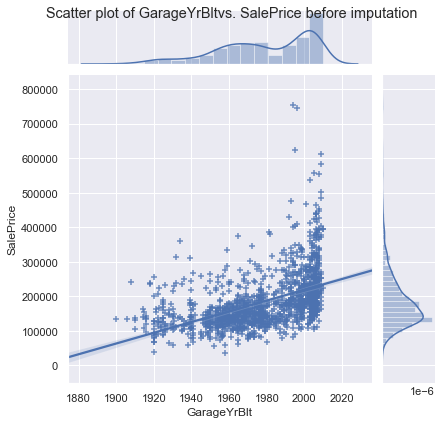

<Figure size 432x288 with 0 Axes>

In [28]:
visualise_floats(dataframe=train
          ,variables=floats_with_nulls
          ,target="SalePrice")

### Imputation of floats

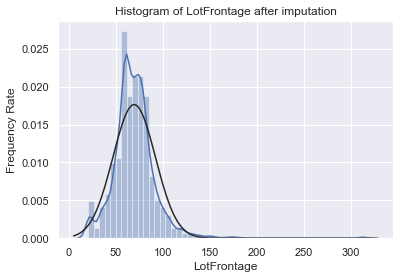

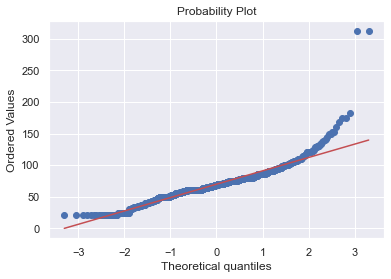

<Figure size 432x288 with 0 Axes>

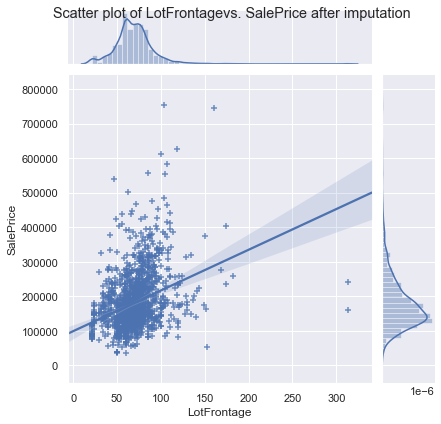

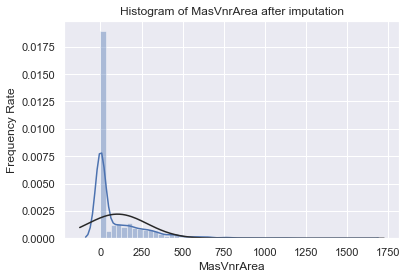

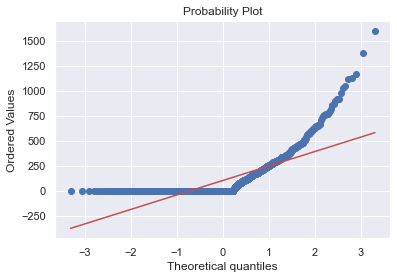

<Figure size 432x288 with 0 Axes>

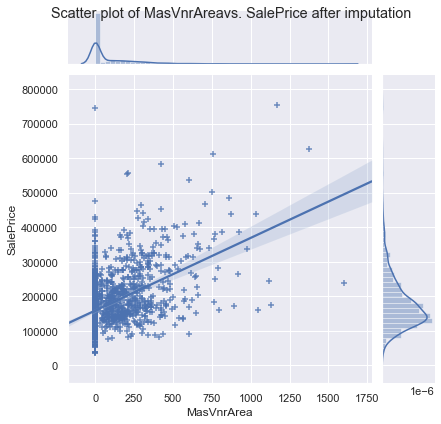

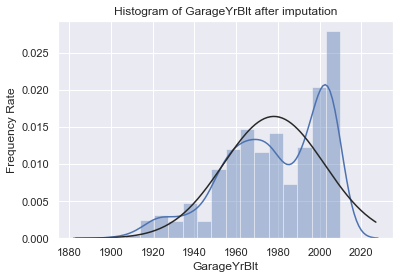

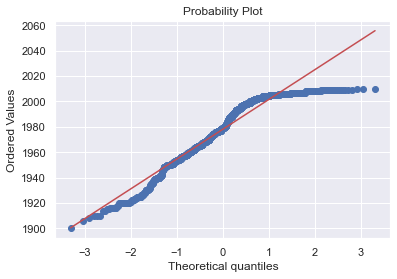

<Figure size 432x288 with 0 Axes>

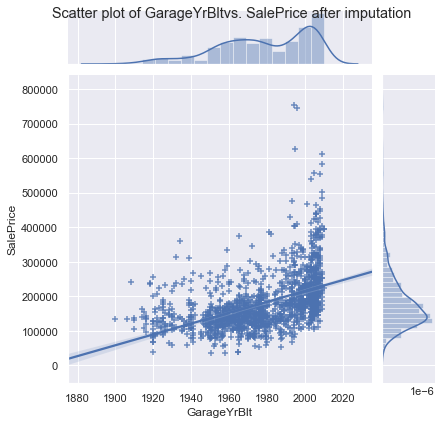

<Figure size 432x288 with 0 Axes>

In [29]:
floats_without_nulls = choose_imputer_and_visualise_floats(dataframe=train
                                                           ,variables=floats_with_nulls
                                                           ,target="SalePrice"
                                                           ,imputer=KNNImputer
                                                           ,strategy=None
                                                           ,weights="distance")
#floats_without_nulls

### Summary statistics of Floats before imputation

In [30]:
#train[floats_with_nulls].describe()

In [31]:
before = pd.DataFrame(train[floats_with_nulls].isnull().sum())
before.T

LotFrontage  MasVnrArea  GarageYrBlt
0          259           8           81

### Summary statistics of Floats after imputation

In [32]:
#floats_without_nulls.describe()

In [33]:
after = pd.DataFrame(floats_without_nulls.isnull().sum())
after.T

LotFrontage  MasVnrArea  GarageYrBlt
0            0           0            0

# 5.2 Category columns imputation

## Find Category columns with null values

In [34]:
category_with_nulls = pd.DataFrame(train.select_dtypes(include=['object']).isnull().sum()) > 0
category_with_nulls = category_with_nulls[category_with_nulls[0] == True].T.columns
category_with_nulls

Index(['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature'],
      dtype='object')

### Print counts of unique values including Null values

In [35]:
count_unique_values(dataframe=train
                    ,variables=category_with_nulls)

Alley count distinct:
Grvl      50
Pave      41
nan     1369
dtype: int64

MasVnrType count distinct:
None       864
BrkFace    445
Stone      128
BrkCmn      15
nan          8
dtype: int64

BsmtQual count distinct:
TA     649
Gd     618
Ex     121
Fa      35
nan     37
dtype: int64

BsmtCond count distinct:
TA     1311
Gd       65
Fa       45
Po        2
nan      37
dtype: int64

BsmtExposure count distinct:
No     953
Av     221
Gd     134
Mn     114
nan     38
dtype: int64

BsmtFinType1 count distinct:
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
nan     37
dtype: int64

BsmtFinType2 count distinct:
Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
nan      38
dtype: int64

Electrical count distinct:
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
nan         1
dtype: int64

FireplaceQu count distinct:
Gd     380
TA     313
Fa      33
Ex      24
Po      20
nan    690
dtype: int64

GarageType count distinct:
Attchd     

### Imputation of characteristics

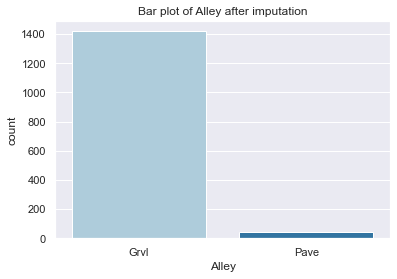

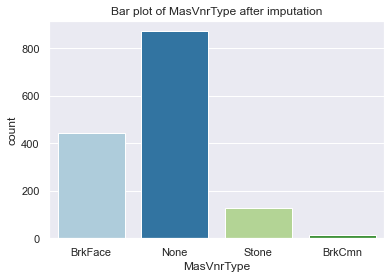

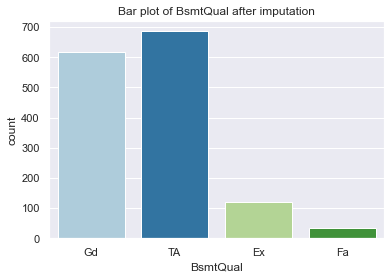

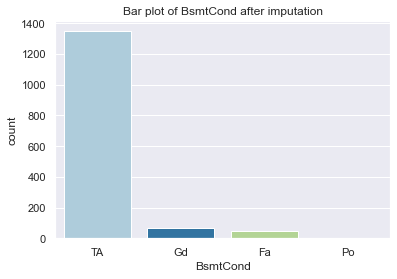

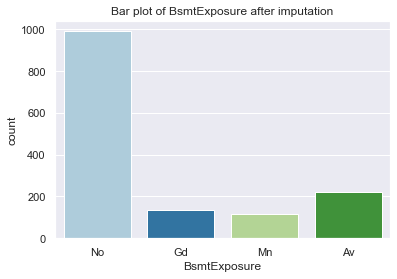

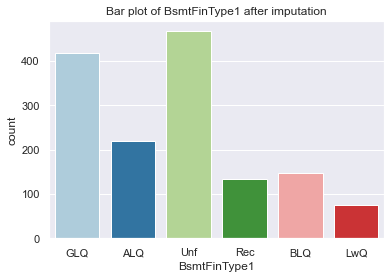

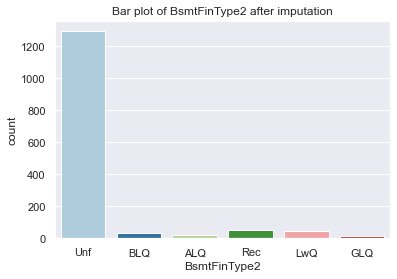

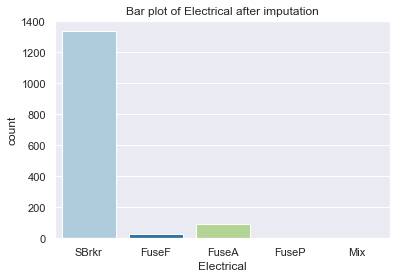

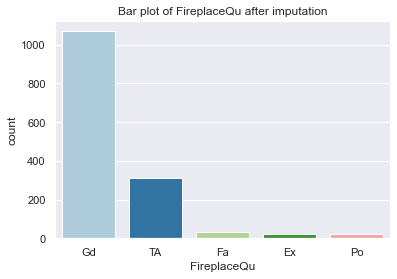

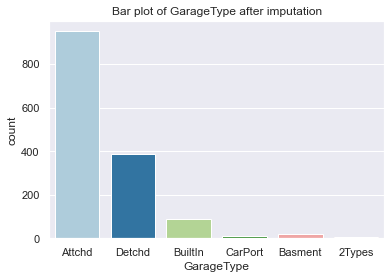

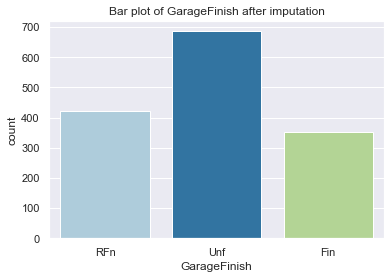

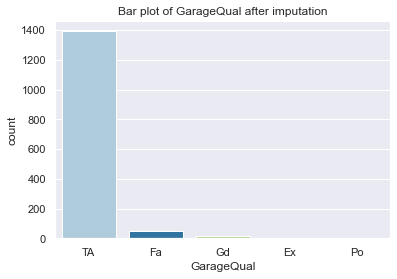

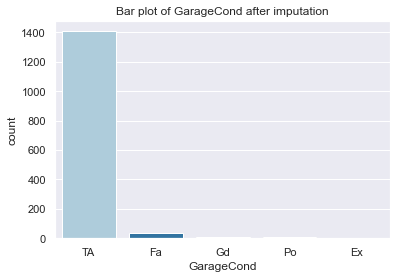

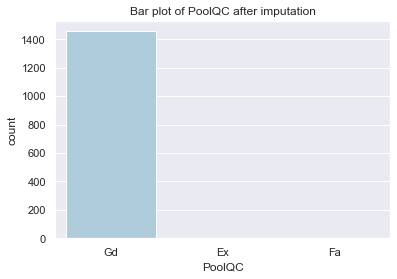

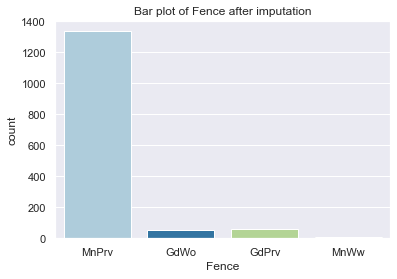

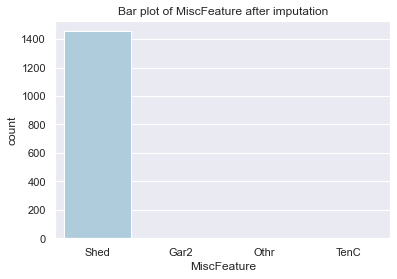

<Figure size 432x288 with 0 Axes>

In [36]:
category_without_nulls = choose_imputer_and_visualise_categories(dataframe=train
                                                                ,variables=category_with_nulls
                                                                ,target=None
                                                                ,imputer=SimpleImputer
                                                                ,strategy="most_frequent"
                                                                ,weights=None)
#category_without_nulls

### Summary statistics of Categories before imputation

In [37]:
#train[category_with_nulls].describe()

In [38]:
before = pd.DataFrame(train[category_with_nulls].isnull().sum())
#before.T

### Summary statistics of Categories after imputation

In [39]:
#category_without_nulls.describe()

In [40]:
after = pd.DataFrame(category_without_nulls.isnull().sum())
#after.T

In [41]:
target = train.iloc[:,-1]

In [42]:
target

0      208500.000
1      181500.000
2      223500.000
3      140000.000
4      250000.000
          ...    
1455   175000.000
1456   210000.000
1457   266500.000
1458   142125.000
1459   147500.000
Name: SalePrice, Length: 1460, dtype: float64

## Replacing original columns with imputed one

#### Replacing Floats

In [43]:
floats_without_nulls.columns

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

In [44]:
train[floats_without_nulls.columns] = floats_without_nulls

#### Replacing Categories

In [45]:
category_without_nulls.columns

Index(['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature'],
      dtype='object')

In [46]:
train[category_without_nulls.columns] = category_without_nulls

# 6. Feature engineering

### Copy of Train

In [47]:
train_imputed = train.copy()
#train_imputed

In [48]:
features_floats = pd.DataFrame(train.select_dtypes(include=['float64'])).columns[:-1]

In [49]:
features_floats

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [50]:
features_objects = pd.DataFrame(train.select_dtypes(include=['object'])).columns

In [51]:
features_objects

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

# 6.1 Polynomial transformations

In [52]:
poly = PolynomialFeatures(2, interaction_only=False).fit(train[features_floats])
fitted = poly.transform(train[features_floats])

In [53]:
fitted = pd.DataFrame(fitted, columns=poly.get_feature_names())
#fitted

In [54]:
train = pd.concat([train, fitted], axis=1)
#train

In [55]:
train.shape

(1460, 783)

In [56]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       ...
       'x32^2', 'x32 x33', 'x32 x34', 'x32 x35', 'x33^2', 'x33 x34', 'x33 x35',
       'x34^2', 'x34 x35', 'x35^2'],
      dtype='object', length=783)

In [57]:
print(pd.DataFrame(train.columns).count())
print(pd.DataFrame(train.columns).nunique())

0    783
dtype: int64
0    783
dtype: int64


# 6.2 Deviations

In [58]:
#train.describe()

In [59]:
train.isnull().sum().sort_values(ascending=False)

x35^2         0
x3 x25        0
x4 x15        0
x4 x14        0
x4 x13        0
             ..
x13 x25       0
x13 x24       0
x13 x23       0
x13 x22       0
MSSubClass    0
Length: 783, dtype: int64

In [60]:
train = add_deviation_features(train.drop(columns=["SalePrice"])
                               ,variables_floats=features_floats
                               ,variables_objects=features_objects)
#train

In [61]:
train.shape

(1460, 2330)

In [62]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       ...
       'SaleCondition_DEVIATION_GarageArea',
       'SaleCondition_DEVIATION_WoodDeckSF',
       'SaleCondition_DEVIATION_OpenPorchSF',
       'SaleCondition_DEVIATION_EnclosedPorch',
       'SaleCondition_DEVIATION_3SsnPorch',
       'SaleCondition_DEVIATION_ScreenPorch',
       'SaleCondition_DEVIATION_PoolArea', 'SaleCondition_DEVIATION_MiscVal',
       'SaleCondition_DEVIATION_MoSold', 'SaleCondition_DEVIATION_YrSold'],
      dtype='object', length=2330)

In [63]:
print(pd.DataFrame(train.columns).count())
print(pd.DataFrame(train.columns).nunique())

0    2330
dtype: int64
0    2330
dtype: int64


# 6.3 Log transforming skew variables

In [64]:
train[train.select_dtypes(include=['uint8']).columns] = train[train.select_dtypes(include=['uint8']).columns].astype(float)

In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 2330 entries, MSSubClass to SaleCondition_DEVIATION_YrSold
dtypes: float64(2287), object(43)
memory usage: 26.0+ MB


In [66]:
mask = train.dtypes == np.float
float_columns = train.columns[mask]

skew_limit = 0.75
skew_values = train[float_columns].skew()
skew_values

MSSubClass                             1.408
LotFrontage                            2.246
LotArea                               12.208
OverallQual                            0.217
OverallCond                            0.693
                                       ...  
SaleCondition_DEVIATION_ScreenPorch    4.090
SaleCondition_DEVIATION_PoolArea      18.340
SaleCondition_DEVIATION_MiscVal       20.938
SaleCondition_DEVIATION_MoSold         0.216
SaleCondition_DEVIATION_YrSold         0.104
Length: 2287, dtype: float64

In [67]:
skew_columns = (skew_values
                .sort_values(ascending=False)
                .to_frame()
                .rename(columns={0:'Skew'})
                .query('abs(Skew) > {}'.format(skew_limit)))

#skew_columns.T

In [68]:
for column in skew_columns.index.values:
    if column == "SalePrice":
        continue
    train[column] = train[column].apply(np.log1p)

In [69]:
train.shape

(1460, 2330)

In [70]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       ...
       'SaleCondition_DEVIATION_GarageArea',
       'SaleCondition_DEVIATION_WoodDeckSF',
       'SaleCondition_DEVIATION_OpenPorchSF',
       'SaleCondition_DEVIATION_EnclosedPorch',
       'SaleCondition_DEVIATION_3SsnPorch',
       'SaleCondition_DEVIATION_ScreenPorch',
       'SaleCondition_DEVIATION_PoolArea', 'SaleCondition_DEVIATION_MiscVal',
       'SaleCondition_DEVIATION_MoSold', 'SaleCondition_DEVIATION_YrSold'],
      dtype='object', length=2330)

In [71]:
print(pd.DataFrame(train.columns).count())
print(pd.DataFrame(train.columns).nunique())

0    2330
dtype: int64
0    2330
dtype: int64


# 6.4 Scaling

In [72]:
#S = StandardScaler().fit(train[features_floats])
S = RobustScaler().fit(train[features_floats])
fitted = S.transform(train[features_floats])

In [73]:
fitted.shape

(1460, 36)

In [74]:
fitted = pd.DataFrame(fitted, columns=features_floats)

In [75]:
#train = pd.concat([train, fitted], axis=1)
train.update(fitted)
#train

In [76]:
train.shape

(1460, 2330)

In [77]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       ...
       'SaleCondition_DEVIATION_GarageArea',
       'SaleCondition_DEVIATION_WoodDeckSF',
       'SaleCondition_DEVIATION_OpenPorchSF',
       'SaleCondition_DEVIATION_EnclosedPorch',
       'SaleCondition_DEVIATION_3SsnPorch',
       'SaleCondition_DEVIATION_ScreenPorch',
       'SaleCondition_DEVIATION_PoolArea', 'SaleCondition_DEVIATION_MiscVal',
       'SaleCondition_DEVIATION_MoSold', 'SaleCondition_DEVIATION_YrSold'],
      dtype='object', length=2330)

In [78]:
print(pd.DataFrame(train.columns).count())
print(pd.DataFrame(train.columns).nunique())

0    2330
dtype: int64
0    2330
dtype: int64


# 6.5 Dummy variables

In [79]:
categories = pd.DataFrame(train.select_dtypes(include=['object']))
#categories

In [80]:
#categories.describe()

### One-hot encoding

In [81]:
one_hot_encode_cols = categories.dtypes[categories.dtypes == np.object]
one_hot_encode_cols = one_hot_encode_cols.index.tolist()
#pd.DataFrame(one_hot_encode_cols).T

In [82]:
train = pd.get_dummies(data=train
                       ,columns=one_hot_encode_cols
                       ,drop_first=True)

In [83]:
train.shape

(1460, 2496)

In [84]:
train.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=2496)

In [85]:
print(pd.DataFrame(train.columns).count())
print(pd.DataFrame(train.columns).nunique())

0    2496
dtype: int64
0    2496
dtype: int64


# 7. Feature selection

In [86]:
variables=train.columns
variables

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=2496)

# 7.1 Variance Threshold

In [87]:
#pd.DataFrame(train.var().sort_values(ascending=True)).T

In [88]:
train.replace([np.inf, -np.inf], np.nan, inplace=True)

In [89]:
train.fillna(0, inplace=True)
#train

In [90]:
from sklearn.feature_selection import VarianceThreshold
X = train
vt = VarianceThreshold(threshold=(.5 * (1 - .5)))
#vt = VarianceThreshold(threshold=0.25)
X_vt = vt.fit_transform(X)
print(vt.get_params())
print(vt.get_support(indices=True))

{'threshold': 0.25}
[   0    1    2 ... 2280 2285 2286]


In [91]:
train_reduced_by_variance = train[train.columns[vt.get_support(indices=True)]]
#train_reduced_by_variance

In [92]:
train_reduced_by_variance.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF2', 'BsmtUnfSF',
       ...
       'SaleCondition_DEVIATION_TotRmsAbvGrd',
       'SaleCondition_DEVIATION_Fireplaces',
       'SaleCondition_DEVIATION_GarageYrBlt',
       'SaleCondition_DEVIATION_GarageCars',
       'SaleCondition_DEVIATION_GarageArea',
       'SaleCondition_DEVIATION_WoodDeckSF',
       'SaleCondition_DEVIATION_OpenPorchSF',
       'SaleCondition_DEVIATION_EnclosedPorch',
       'SaleCondition_DEVIATION_MoSold', 'SaleCondition_DEVIATION_YrSold'],
      dtype='object', length=1836)

In [93]:
train = train_reduced_by_variance

In [94]:
train.shape

(1460, 1836)

In [95]:
train.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF2', 'BsmtUnfSF',
       ...
       'SaleCondition_DEVIATION_TotRmsAbvGrd',
       'SaleCondition_DEVIATION_Fireplaces',
       'SaleCondition_DEVIATION_GarageYrBlt',
       'SaleCondition_DEVIATION_GarageCars',
       'SaleCondition_DEVIATION_GarageArea',
       'SaleCondition_DEVIATION_WoodDeckSF',
       'SaleCondition_DEVIATION_OpenPorchSF',
       'SaleCondition_DEVIATION_EnclosedPorch',
       'SaleCondition_DEVIATION_MoSold', 'SaleCondition_DEVIATION_YrSold'],
      dtype='object', length=1836)

In [96]:
print(pd.DataFrame(train.columns).count())
print(pd.DataFrame(train.columns).nunique())

0    1836
dtype: int64
0    1836
dtype: int64


# 7.2 Univariate feature selection

In [97]:
k_variables = round((pd.DataFrame(train.columns).count())/3).astype("int64")
k_variables

0    612
dtype: int64

In [98]:
from sklearn.feature_selection import SelectKBest, f_regression
X = train
y = target

#select_features = SelectKBest(f_regression, k=10).fit(X, y)
select_features = SelectKBest(f_regression, k=612).fit(X, y)
select_features.get_support()
train = train[train.columns[select_features.get_support(indices=True)]]

In [99]:
train.shape

(1460, 612)

In [100]:
train.columns

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       ...
       'SaleType_DEVIATION_Fireplaces', 'SaleType_DEVIATION_GarageCars',
       'SaleType_DEVIATION_GarageArea', 'SaleCondition_DEVIATION_OverallQual',
       'SaleCondition_DEVIATION_GrLivArea', 'SaleCondition_DEVIATION_FullBath',
       'SaleCondition_DEVIATION_TotRmsAbvGrd',
       'SaleCondition_DEVIATION_Fireplaces',
       'SaleCondition_DEVIATION_GarageCars',
       'SaleCondition_DEVIATION_GarageArea'],
      dtype='object', length=612)

# 7.3 VIF - variance inflation factor

In [101]:
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from sklearn.linear_model import LinearRegression

def sklearn_vif(exogs, data):

    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # form input data for each exogenous variable
    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        X, y = data[not_exog], data[exog]

        # extract r-squared from the fit
        r_squared = LinearRegression(n_jobs=-1).fit(X, y).score(X, y)

        # calculate VIF
        vif = 1/(1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif

In [102]:
VIF = sklearn_vif(train, train)

In [103]:
VIF.sort_values(by="VIF", ascending=True).T.columns

Index(['GarageType_DEVIATION_GrLivArea', 'Electrical_DEVIATION_YearBuilt',
       'BsmtFinType1_DEVIATION_GrLivArea', 'MasVnrType_DEVIATION_GrLivArea',
       'HeatingQC_DEVIATION_GrLivArea', 'Foundation_DEVIATION_GrLivArea',
       'ExterQual_DEVIATION_OverallQual', 'x27 x28',
       'Neighborhood_DEVIATION_OverallQual', 'FireplaceQu_DEVIATION_GrLivArea',
       ...
       'Utilities_DEVIATION_Fireplaces', 'PoolQC_DEVIATION_GarageCars',
       'PoolQC_DEVIATION_Fireplaces', 'PoolQC_DEVIATION_TotRmsAbvGrd',
       'PoolQC_DEVIATION_FullBath', 'Utilities_DEVIATION_GarageYrBlt',
       'PoolQC_DEVIATION_MasVnrArea', 'PoolQC_DEVIATION_YearBuilt',
       'PoolQC_DEVIATION_GarageYrBlt', 'OverallQual'],
      dtype='object', length=612)

In [104]:
train_reduced_by_vif = pd.DataFrame(VIF.T.iloc[0].sort_values(ascending=True)) < 10
train_reduced_by_vif = train_reduced_by_vif[train_reduced_by_vif['VIF'] == True]
train_reduced_by_vif = train_reduced_by_vif.T

In [105]:
train = train[train_reduced_by_vif.columns]

In [106]:
train.shape

(1460, 21)

In [107]:
train.columns

Index(['GarageType_DEVIATION_GrLivArea', 'Electrical_DEVIATION_YearBuilt',
       'BsmtFinType1_DEVIATION_GrLivArea', 'MasVnrType_DEVIATION_GrLivArea',
       'HeatingQC_DEVIATION_GrLivArea', 'Foundation_DEVIATION_GrLivArea',
       'ExterQual_DEVIATION_OverallQual', 'x27 x28',
       'Neighborhood_DEVIATION_OverallQual', 'FireplaceQu_DEVIATION_GrLivArea',
       'x23 x27', 'x7 x27', 'KitchenQual_DEVIATION_OverallQual',
       'Exterior1st_DEVIATION_GrLivArea', 'FireplaceQu_DEVIATION_TotalBsmtSF',
       'LotShape_DEVIATION_GrLivArea', 'BsmtQual_DEVIATION_OverallQual',
       'HouseStyle_DEVIATION_GrLivArea', 'HouseStyle_DEVIATION_1stFlrSF',
       'HouseStyle_DEVIATION_TotalBsmtSF', 'Exterior2nd_DEVIATION_GrLivArea'],
      dtype='object')

# 7.4 Tree-based feature selection

In [108]:
# from sklearn.tree import ExtraTreeRegressor
# from sklearn.feature_selection import SelectFromModel
# X = train
# y = target
# X.shape

# clf = ExtraTreeRegressor()
# clf = clf.fit(X, y)

# model = SelectFromModel(clf, prefit=True)

In [109]:
# train = train[train.columns[model.get_support(indices=True)]]

In [110]:
train.shape

(1460, 21)

In [111]:
train.columns

Index(['GarageType_DEVIATION_GrLivArea', 'Electrical_DEVIATION_YearBuilt',
       'BsmtFinType1_DEVIATION_GrLivArea', 'MasVnrType_DEVIATION_GrLivArea',
       'HeatingQC_DEVIATION_GrLivArea', 'Foundation_DEVIATION_GrLivArea',
       'ExterQual_DEVIATION_OverallQual', 'x27 x28',
       'Neighborhood_DEVIATION_OverallQual', 'FireplaceQu_DEVIATION_GrLivArea',
       'x23 x27', 'x7 x27', 'KitchenQual_DEVIATION_OverallQual',
       'Exterior1st_DEVIATION_GrLivArea', 'FireplaceQu_DEVIATION_TotalBsmtSF',
       'LotShape_DEVIATION_GrLivArea', 'BsmtQual_DEVIATION_OverallQual',
       'HouseStyle_DEVIATION_GrLivArea', 'HouseStyle_DEVIATION_1stFlrSF',
       'HouseStyle_DEVIATION_TotalBsmtSF', 'Exterior2nd_DEVIATION_GrLivArea'],
      dtype='object')

In [112]:
print(pd.DataFrame(train.columns).count())
print(pd.DataFrame(train.columns).nunique())

0    21
dtype: int64
0    21
dtype: int64


# 7.5 Correlations

In [113]:
plt.subplots(figsize=(10,10))
matrix = np.triu(train.corr())
sns_plot = sns.heatmap(train.corr(), annot=True, mask=matrix)
fig = sns_plot.get_figure()
fig.savefig("corr_matrix.jpg")
plt.clf()

<Figure size 720x720 with 0 Axes>

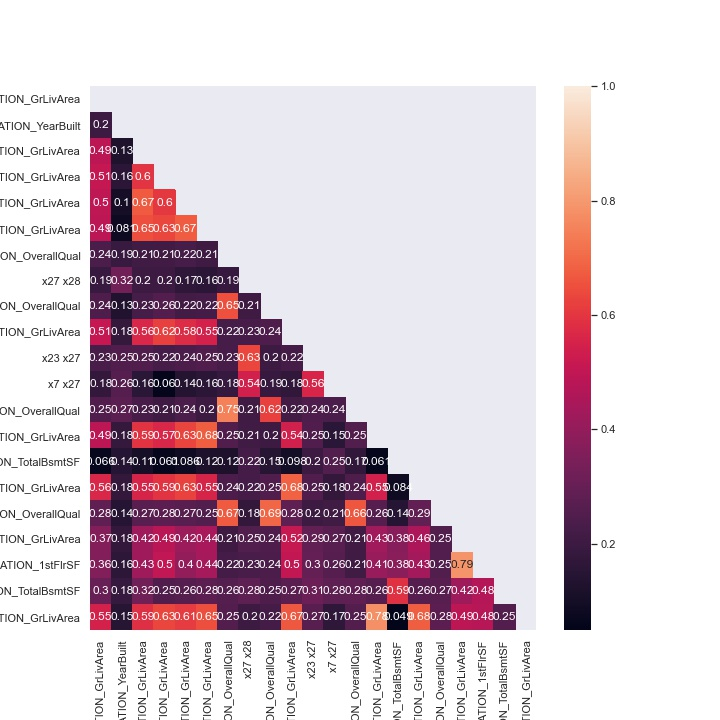

In [114]:
Image(filename='corr_matrix.jpg') # Show pairplot as image

# 7.6 Corralation against Target

In [115]:
target_train = pd.concat([target,train],axis=1)

In [116]:
corr_target = target_train[target_train.columns].corr()['SalePrice'][:-1]
#pd.DataFrame(corr_target.sort_values(ascending=False)).T

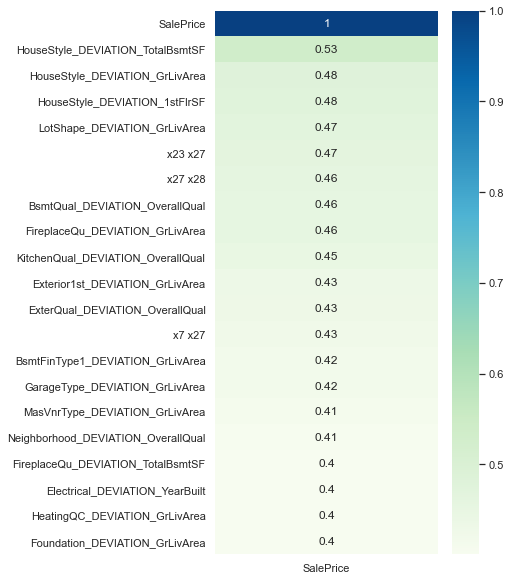

<Figure size 432x288 with 0 Axes>

In [117]:
plt.subplots(figsize=(5,10))
sns_plot = sns.heatmap(corr_target.sort_values(ascending=False).to_frame(),annot=True, annot_kws={'size':12},cmap="GnBu")
plt.show()
fig = sns_plot.get_figure()
fig.savefig("corr_target.jpg")
plt.clf()

# 7.7 Pairplot

In [118]:
# plt.subplots(figsize=(20,20))
# sns.set_context('notebook')
# sns.set_style('white')
# #plt.show()
# fig = sns.pairplot(target_train)
# fig.savefig("pairplot.jpg")
# plt.clf()

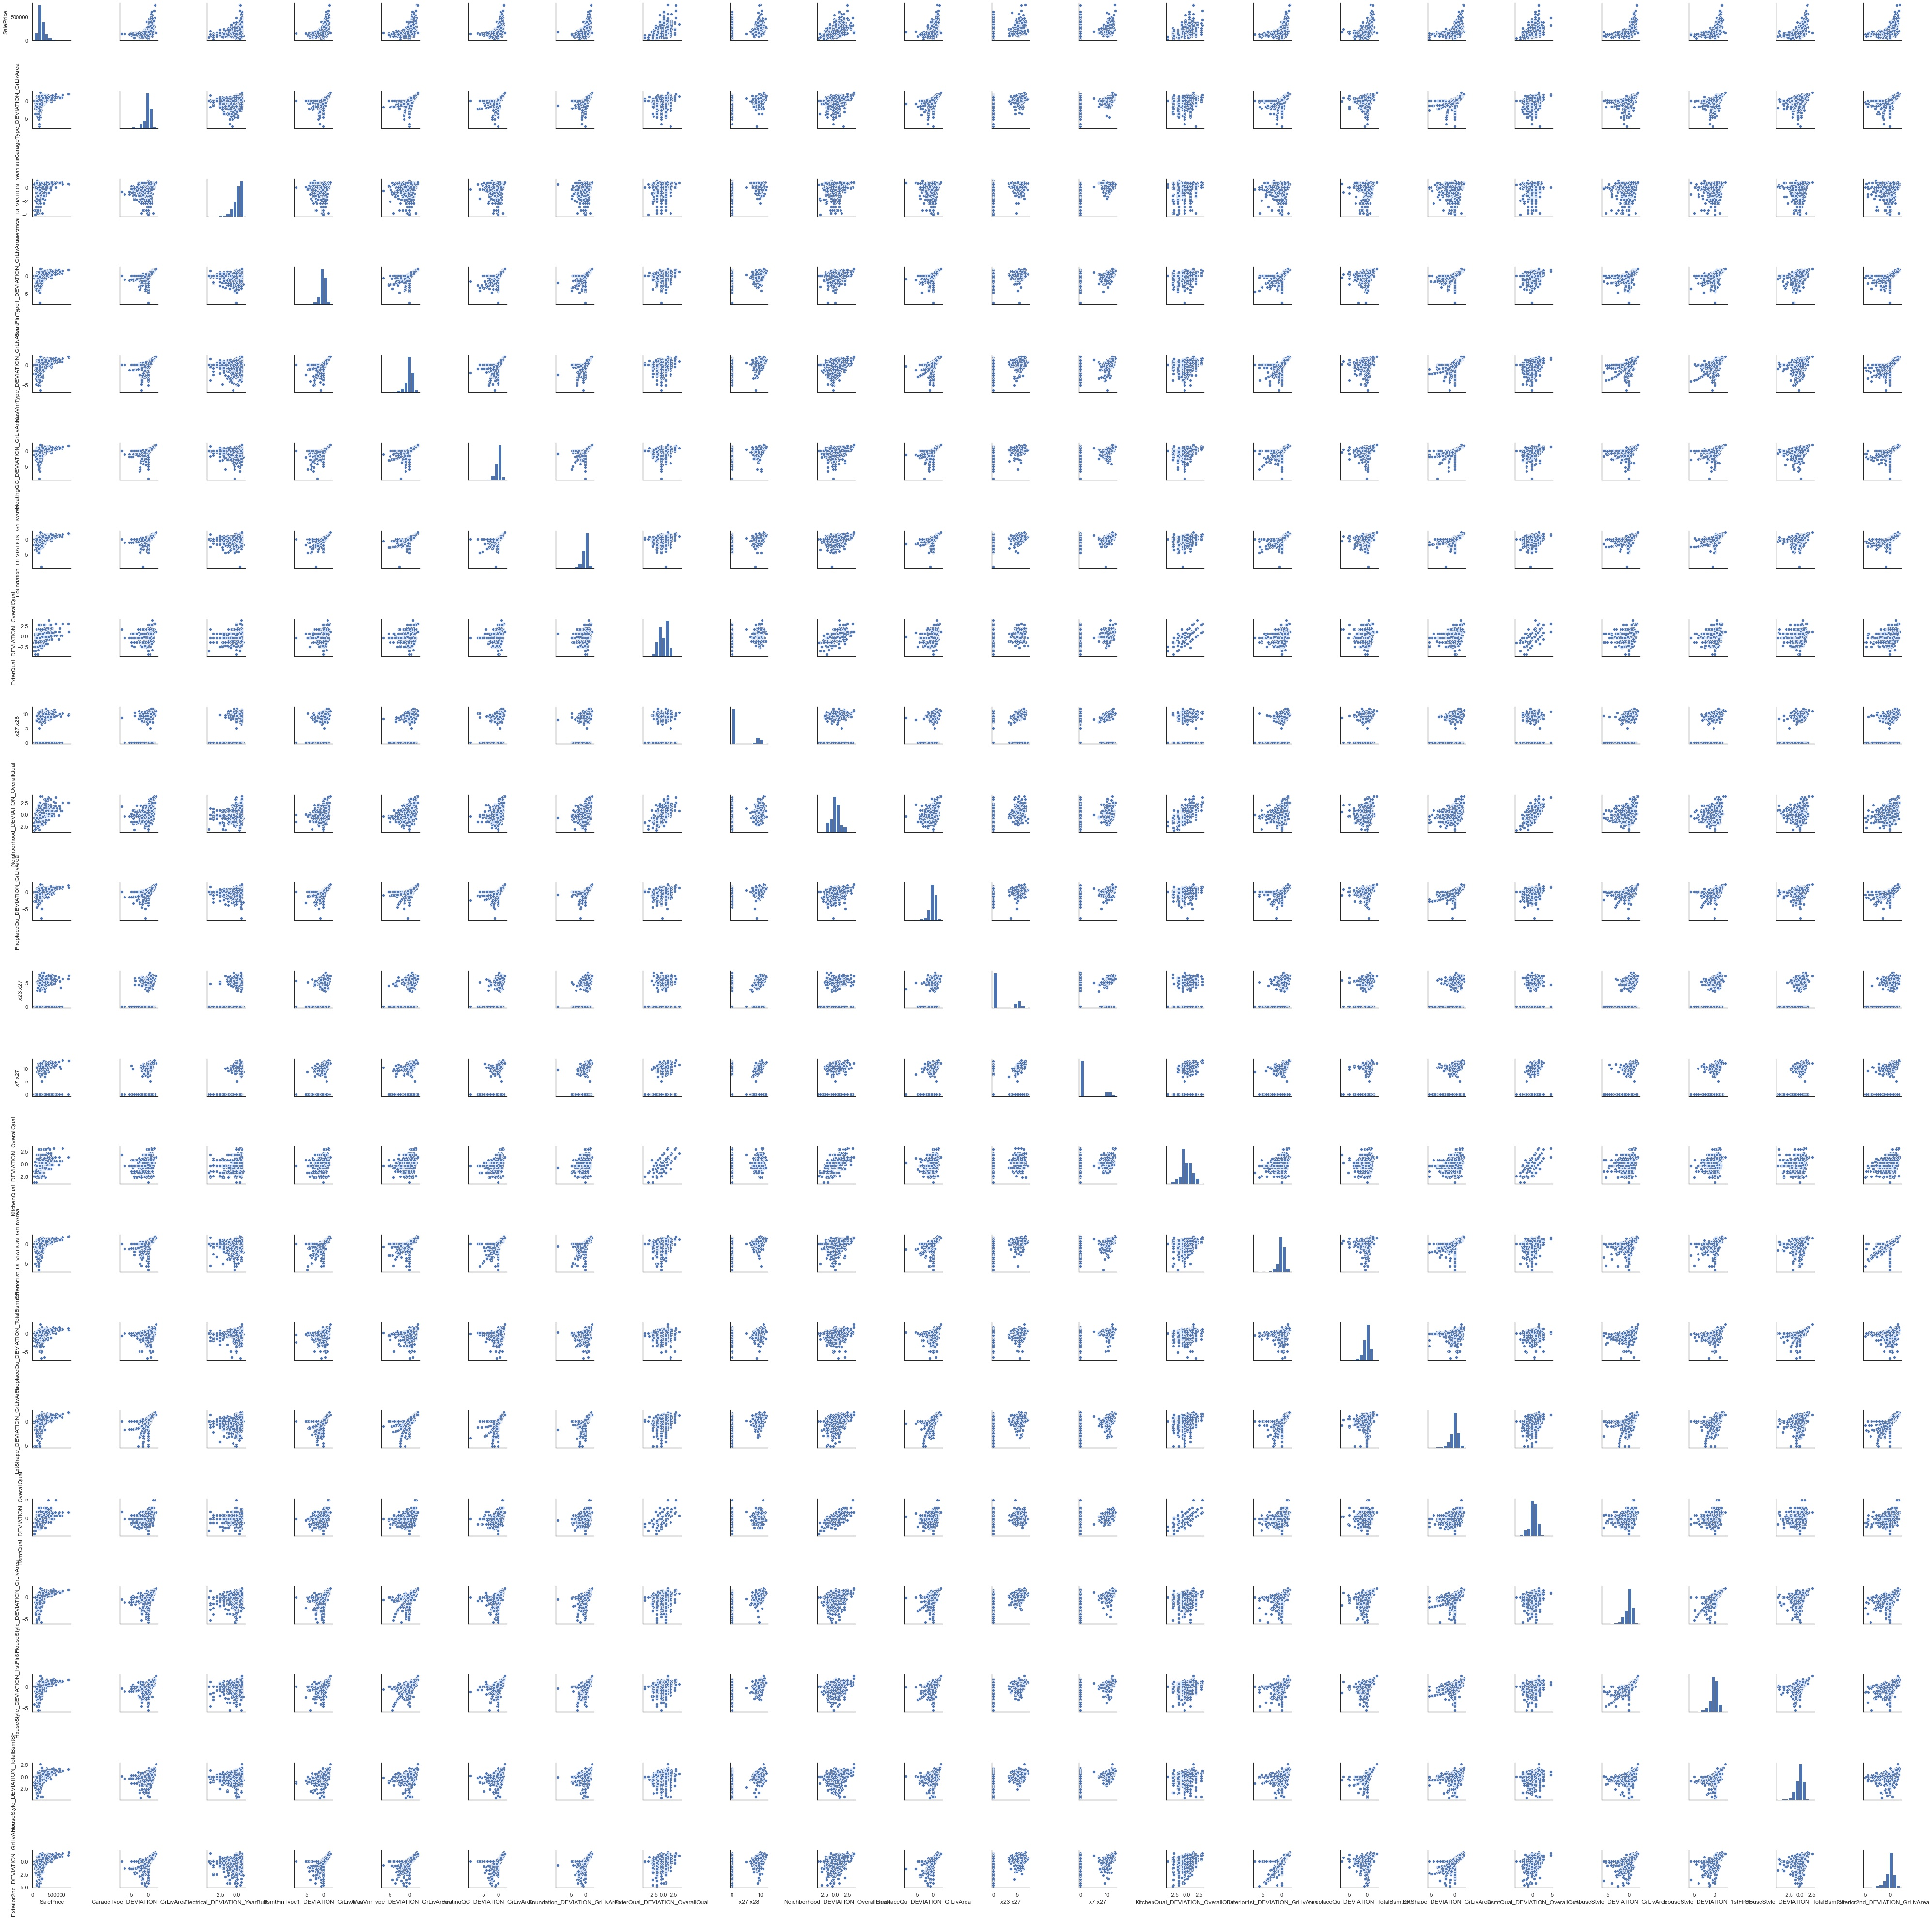

In [119]:
Image(filename='pairplot.jpg')

# 8. Cleaning and Feature Engineering of Test data set

In [120]:
test = pd.read_csv('test.csv')
test_index = test["Id"]
#test_index

In [121]:
test = test.drop(columns="Id", axis=1)
#test

In [122]:
#test.describe()

In [123]:
floats_with_nulls = pd.DataFrame(test.select_dtypes(include=['float64']).isnull().sum()) > 0
floats_with_nulls = floats_with_nulls[floats_with_nulls[0] == True].T.columns
floats_with_nulls

Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
       'GarageCars', 'GarageArea'],
      dtype='object')

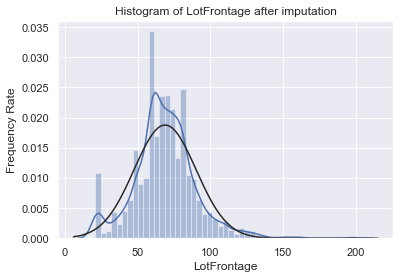

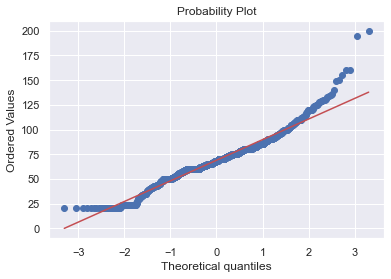

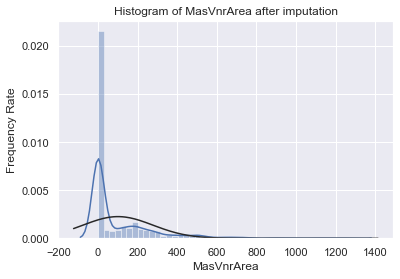

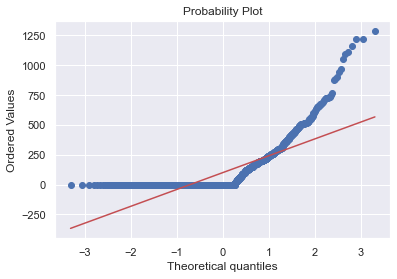

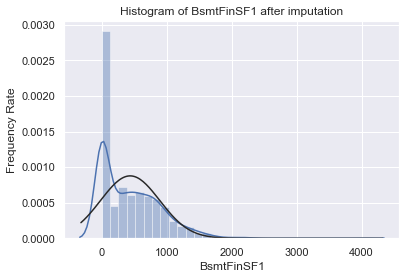

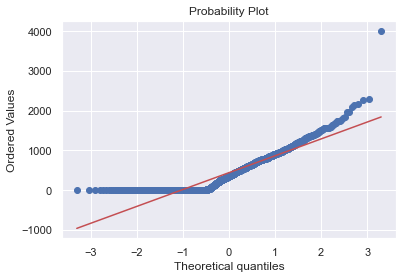

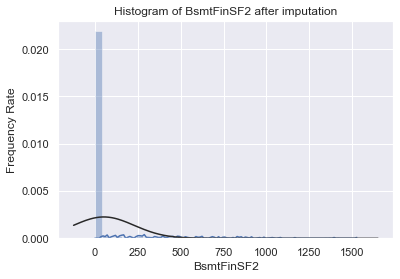

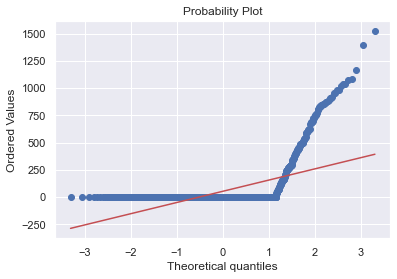

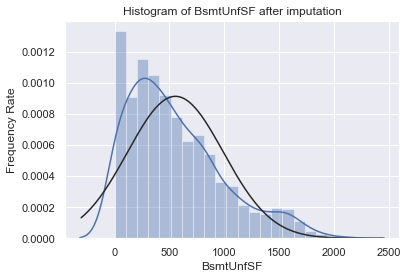

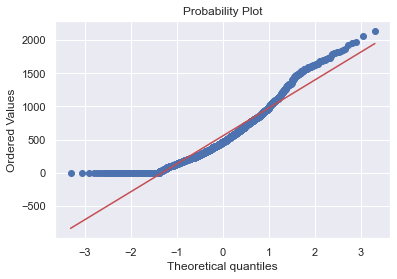

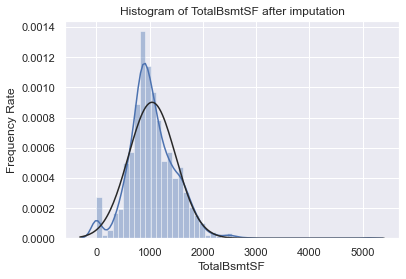

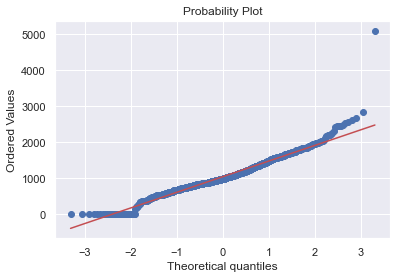

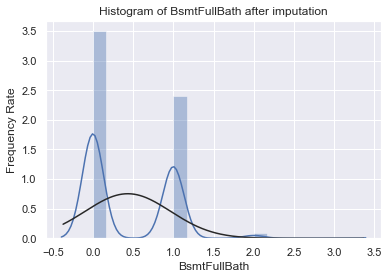

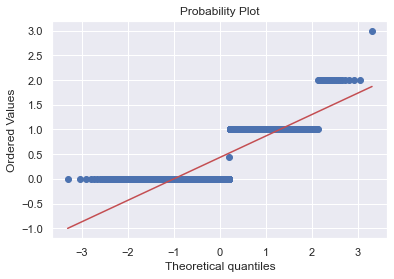

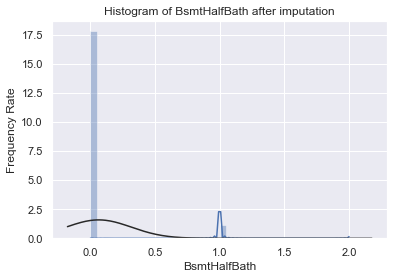

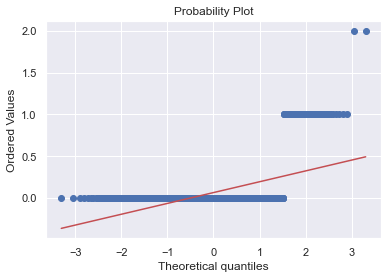

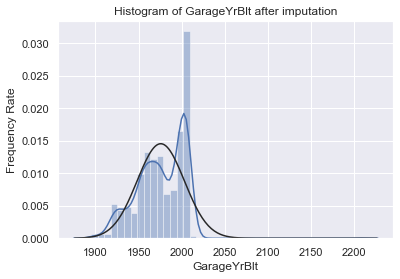

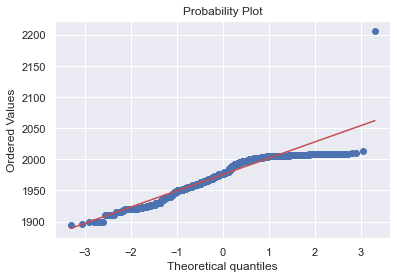

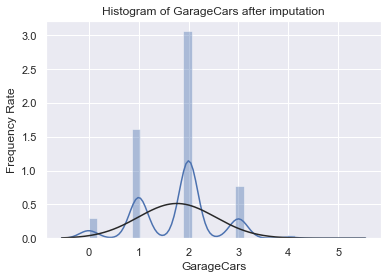

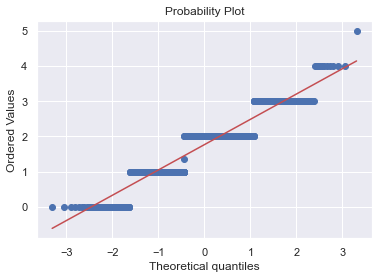

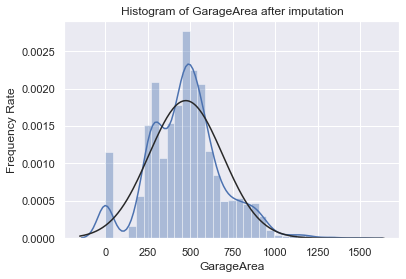

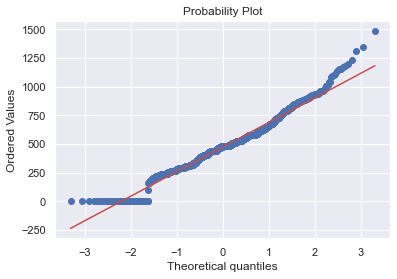

<Figure size 432x288 with 0 Axes>

In [124]:
floats_without_nulls = choose_imputer_and_visualise_floats(dataframe=test
                                                           ,variables=floats_with_nulls
                                                           ,target=None
                                                           ,imputer=KNNImputer
                                                           ,strategy=None
                                                           ,weights="distance")
#floats_without_nulls

In [125]:
#pd.DataFrame(floats_without_nulls.isnull().sum() > 0).T

In [126]:
category_with_nulls = pd.DataFrame(test.select_dtypes(include=['object']).isnull().sum()) > 0
category_with_nulls = category_with_nulls[category_with_nulls[0] == True].T.columns
category_with_nulls

Index(['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType'],
      dtype='object')

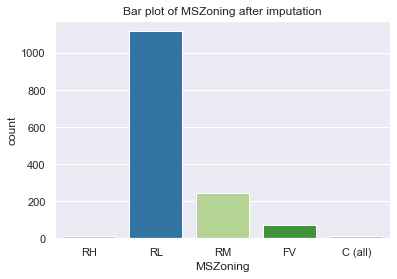

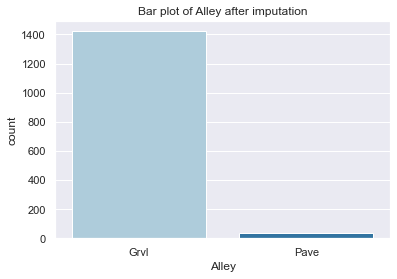

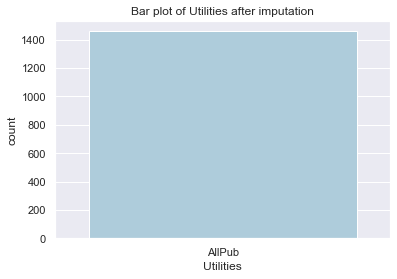

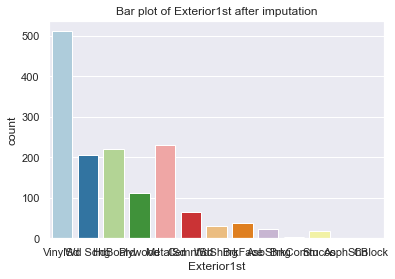

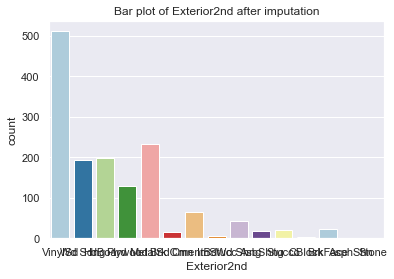

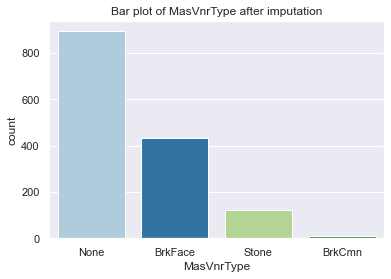

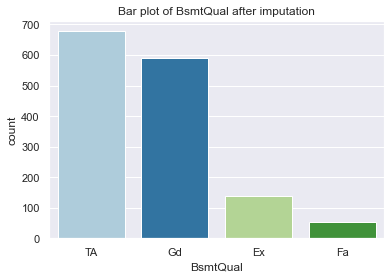

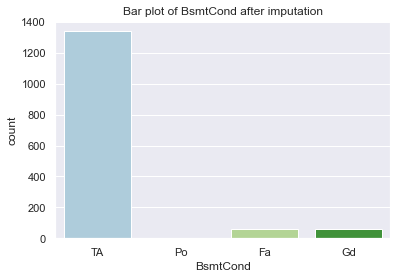

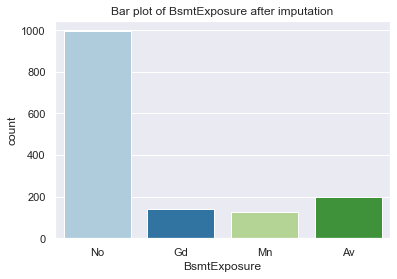

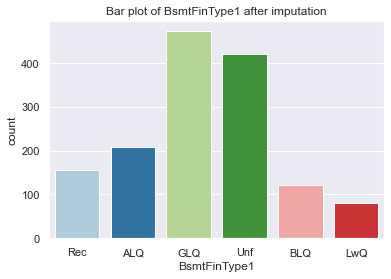

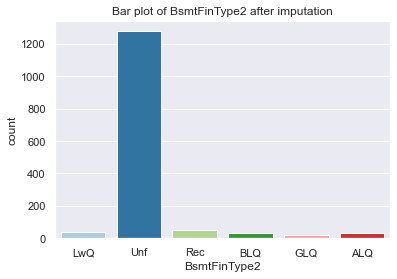

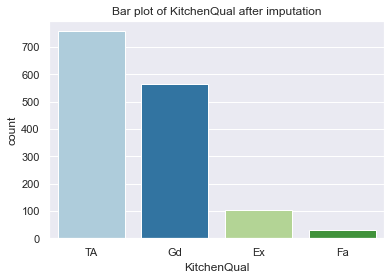

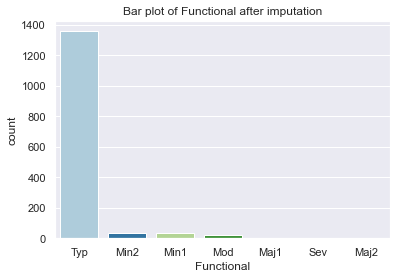

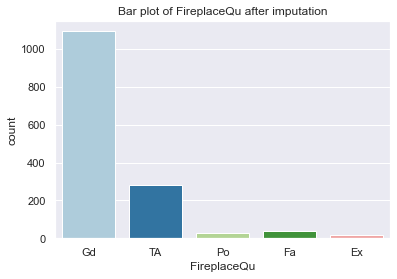

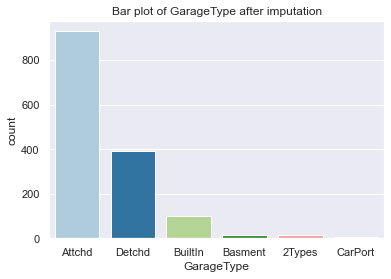

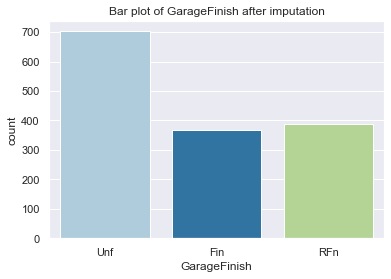

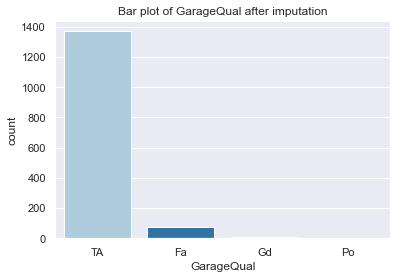

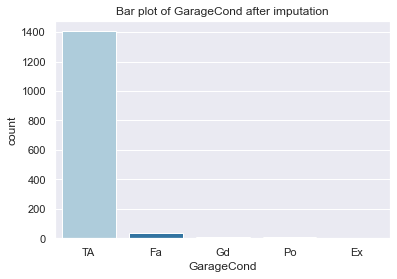

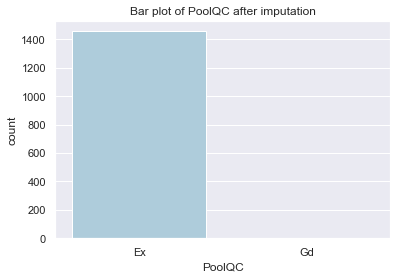

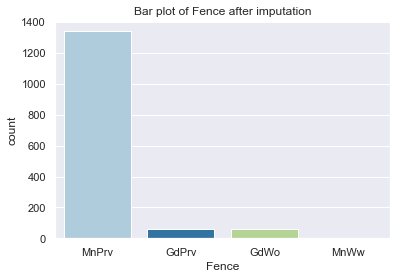

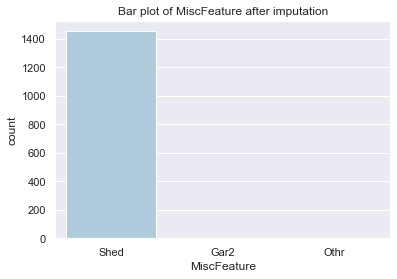

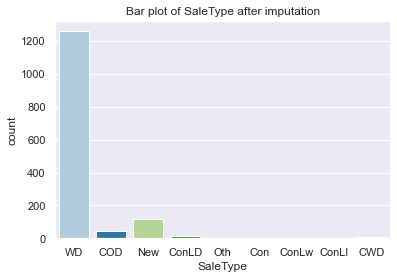

<Figure size 432x288 with 0 Axes>

In [127]:
category_without_nulls = choose_imputer_and_visualise_categories(dataframe=test
                                                                ,variables=category_with_nulls
                                                                ,target=None
                                                                ,imputer=SimpleImputer
                                                                ,strategy="most_frequent"
                                                                ,weights=None)
#category_without_nulls

In [128]:
#pd.DataFrame(category_without_nulls.isnull().sum() > 0).T

In [129]:
test[floats_without_nulls.columns] = floats_without_nulls
#test

In [130]:
test[category_without_nulls.columns] = category_without_nulls
#test

In [131]:
test.shape

(1459, 79)

In [132]:
test[test.select_dtypes(include=['int64', "uint8"]).columns] = test[test.select_dtypes(include=['int64', "uint8"]).columns].astype(float)

In [133]:
#features_floats = pd.DataFrame(test.select_dtypes(include=['float64'])).columns
features_floats

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [134]:
#features_objects = pd.DataFrame(test.select_dtypes(include=['object'])).columns
features_objects

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [135]:
#poly = PolynomialFeatures(2, interaction_only=False)
fitted = poly.transform(test[features_floats])

In [136]:
fitted = pd.DataFrame(fitted, columns=poly.get_feature_names())
#fitted

In [137]:
test = pd.concat([test, fitted], axis=1)
#test

In [138]:
test.shape

(1459, 782)

In [139]:
test.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       ...
       'x32^2', 'x32 x33', 'x32 x34', 'x32 x35', 'x33^2', 'x33 x34', 'x33 x35',
       'x34^2', 'x34 x35', 'x35^2'],
      dtype='object', length=782)

In [140]:
print(pd.DataFrame(test.columns).count())
print(pd.DataFrame(test.columns).nunique())

0    782
dtype: int64
0    782
dtype: int64


In [141]:
test = add_deviation_features(test
                               ,variables_floats=features_floats
                               ,variables_objects=features_objects)
#test

In [142]:
test.shape

(1459, 2330)

In [143]:
test.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       ...
       'SaleCondition_DEVIATION_GarageArea',
       'SaleCondition_DEVIATION_WoodDeckSF',
       'SaleCondition_DEVIATION_OpenPorchSF',
       'SaleCondition_DEVIATION_EnclosedPorch',
       'SaleCondition_DEVIATION_3SsnPorch',
       'SaleCondition_DEVIATION_ScreenPorch',
       'SaleCondition_DEVIATION_PoolArea', 'SaleCondition_DEVIATION_MiscVal',
       'SaleCondition_DEVIATION_MoSold', 'SaleCondition_DEVIATION_YrSold'],
      dtype='object', length=2330)

In [144]:
print(pd.DataFrame(test.columns).count())
print(pd.DataFrame(test.columns).nunique())

0    2330
dtype: int64
0    2330
dtype: int64


In [145]:
mask = test.dtypes == np.float
float_columns = test.columns[mask]

skew_limit = 0.75
skew_values = test[float_columns].skew()
skew_values

MSSubClass                             1.347
LotFrontage                            0.624
LotArea                                3.115
OverallQual                            0.181
OverallCond                            0.449
                                       ...  
SaleCondition_DEVIATION_ScreenPorch    3.846
SaleCondition_DEVIATION_PoolArea      18.337
SaleCondition_DEVIATION_MiscVal       16.429
SaleCondition_DEVIATION_MoSold         0.180
SaleCondition_DEVIATION_YrSold         0.179
Length: 2287, dtype: float64

In [146]:
skew_columns = (skew_values
                .sort_values(ascending=False)
                .to_frame()
                .rename(columns={0:'Skew'})
                .query('abs(Skew) > {}'.format(skew_limit)))

#skew_columns.T

In [147]:
for column in skew_columns.index.values:
    if column == "SalePrice":
        continue
    test[column] = test[column].apply(np.log1p)

In [148]:
test.shape

(1459, 2330)

In [149]:
test.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       ...
       'SaleCondition_DEVIATION_GarageArea',
       'SaleCondition_DEVIATION_WoodDeckSF',
       'SaleCondition_DEVIATION_OpenPorchSF',
       'SaleCondition_DEVIATION_EnclosedPorch',
       'SaleCondition_DEVIATION_3SsnPorch',
       'SaleCondition_DEVIATION_ScreenPorch',
       'SaleCondition_DEVIATION_PoolArea', 'SaleCondition_DEVIATION_MiscVal',
       'SaleCondition_DEVIATION_MoSold', 'SaleCondition_DEVIATION_YrSold'],
      dtype='object', length=2330)

In [150]:
print(pd.DataFrame(test.columns).count())
print(pd.DataFrame(test.columns).nunique())

0    2330
dtype: int64
0    2330
dtype: int64


In [151]:
test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [152]:
#S = StandardScaler(copy=False)
fitted = S.transform(test[features_floats])

In [153]:
fitted = pd.DataFrame(fitted,columns=features_floats)

In [154]:
#test = pd.concat([test, fitted], axis=1)
test.update(fitted)
#test

In [155]:
test.shape

(1459, 2330)

In [156]:
test.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       ...
       'SaleCondition_DEVIATION_GarageArea',
       'SaleCondition_DEVIATION_WoodDeckSF',
       'SaleCondition_DEVIATION_OpenPorchSF',
       'SaleCondition_DEVIATION_EnclosedPorch',
       'SaleCondition_DEVIATION_3SsnPorch',
       'SaleCondition_DEVIATION_ScreenPorch',
       'SaleCondition_DEVIATION_PoolArea', 'SaleCondition_DEVIATION_MiscVal',
       'SaleCondition_DEVIATION_MoSold', 'SaleCondition_DEVIATION_YrSold'],
      dtype='object', length=2330)

In [157]:
print(pd.DataFrame(test.columns).count())
print(pd.DataFrame(test.columns).nunique())

0    2330
dtype: int64
0    2330
dtype: int64


In [158]:
one_hot_encode_cols = category_without_nulls.dtypes[category_without_nulls.dtypes == np.object]
one_hot_encode_cols = one_hot_encode_cols.index.tolist()
#pd.DataFrame(one_hot_encode_cols).T

In [159]:
test = pd.get_dummies(data=test
                        ,columns=one_hot_encode_cols
                        ,drop_first=True)

In [160]:
test[test.select_dtypes(include=['uint8']).columns] = test[test.select_dtypes(include=['uint8']).columns].astype(float)

In [161]:
test.shape

(1459, 2402)

In [162]:
test.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       ...
       'MiscFeature_Othr', 'MiscFeature_Shed', 'SaleType_CWD', 'SaleType_Con',
       'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New',
       'SaleType_Oth', 'SaleType_WD'],
      dtype='object', length=2402)

In [163]:
print(pd.DataFrame(test.columns).count())
print(pd.DataFrame(test.columns).nunique())

0    2402
dtype: int64
0    2402
dtype: int64


# 9. Double check of NULL values

In [164]:
train.shape

(1460, 21)

In [165]:
print(pd.DataFrame(train.columns).count())
print(pd.DataFrame(train.columns).nunique())

0    21
dtype: int64
0    21
dtype: int64


In [166]:
nulls = pd.DataFrame(train.isnull().sum()) > 0
nulls = nulls[nulls[0] == True].T.columns
nulls

Index([], dtype='object')

In [167]:
test.shape

(1459, 2402)

In [168]:
print(pd.DataFrame(test.columns).count())
print(pd.DataFrame(test.columns).nunique())

0    2402
dtype: int64
0    2402
dtype: int64


In [169]:
nulls = pd.DataFrame(test.isnull().sum()) > 0
nulls = nulls[nulls[0] == True].T.columns
nulls

Index(['MSZoning_DEVIATION_MSSubClass', 'MSZoning_DEVIATION_LotFrontage',
       'MSZoning_DEVIATION_LotArea', 'MSZoning_DEVIATION_OverallCond',
       'MSZoning_DEVIATION_MasVnrArea', 'MSZoning_DEVIATION_BsmtFinSF1',
       'MSZoning_DEVIATION_BsmtFinSF2', 'MSZoning_DEVIATION_BsmtUnfSF',
       'MSZoning_DEVIATION_1stFlrSF', 'MSZoning_DEVIATION_2ndFlrSF',
       ...
       'SaleCondition_DEVIATION_BsmtHalfBath',
       'SaleCondition_DEVIATION_KitchenAbvGr',
       'SaleCondition_DEVIATION_TotRmsAbvGrd',
       'SaleCondition_DEVIATION_Fireplaces',
       'SaleCondition_DEVIATION_WoodDeckSF',
       'SaleCondition_DEVIATION_OpenPorchSF',
       'SaleCondition_DEVIATION_3SsnPorch',
       'SaleCondition_DEVIATION_ScreenPorch',
       'SaleCondition_DEVIATION_PoolArea', 'SaleCondition_DEVIATION_MiscVal'],
      dtype='object', length=931)

# 10. Predictions

In [170]:
test.replace([np.inf, -np.inf], np.nan, inplace=True)
test.fillna(0, inplace=True)

train.replace([np.inf, -np.inf], np.nan, inplace=True)
train.fillna(0, inplace=True)

### Various models to try

In [171]:
X_train = train
y_train = target

X_test = test[train.columns]

In [172]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [173]:
lin_params = dict(alpha=np.logspace(1,7,7), normalize=(False, True))
for_params = dict(n_estimators=np.linspace(10,40,4).astype(int), min_samples_split=(2,3), min_samples_leaf=(1,2,3))
gbr_params = dict(n_estimators=np.linspace(100,300,3).astype(int), min_samples_split=(2,3))

In [174]:
ridge_grid = GridSearchCV(Ridge(random_state=42), lin_params, cv=10, n_jobs=-1)
forest_grid = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), for_params, cv=10, n_jobs=-1)
gbr_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), gbr_params, cv=10, n_jobs=-1)

In [175]:
ridge_grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=42,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07]),
                         'normalize': (False, True)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [176]:
forest_grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=

In [177]:
gbr_grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                

In [178]:
print(f'Ridge:\n\t *best params: {ridge_grid.best_params_}\n\t *best score: {ridge_grid.best_score_}')
print(f'Forest:\n\t *best params: {forest_grid.best_params_}\n\t *best score: {forest_grid.best_score_}')
print(f'Gradient Boost:\n\t *best params: {gbr_grid.best_params_}\n\t *best score: {gbr_grid.best_score_}')

Ridge:
	 *best params: {'alpha': 100.0, 'normalize': False}
	 *best score: 0.5985726019677388
Forest:
	 *best params: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40}
	 *best score: 0.7928138212308975
Gradient Boost:
	 *best params: {'min_samples_split': 2, 'n_estimators': 300}
	 *best score: 0.8142546773251418


In [179]:
best_ridge = Ridge(alpha=100, normalize=False)
best_forest = RandomForestRegressor(min_samples_leaf=1, min_samples_split=2, n_estimators=40)
best_gbr = GradientBoostingRegressor(min_samples_split=2, n_estimators=300)

[Text(0, 0.5, 'Predictions'),
 Text(0.5, 0, 'Ground truth'),
 Text(0.5, 1.0, 'Ames, Iowa House Price Predictions vs Truth')]

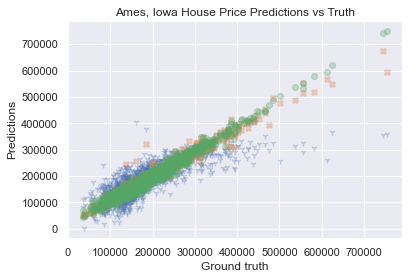

In [180]:
# Ridge
best_ridge.fit(X_train, y_train)
predicted_ridge_train = best_ridge.predict(X_train)
predicted_ridge_test = best_ridge.predict(X_test)

ax = plt.axes()
ax.scatter(y_train, predicted_ridge_train, alpha=.3, marker="1")
ax.set(xlabel='Ground truth', ylabel='Predictions', title='Ames, Iowa House Price Predictions vs Truth')

# Random Forest
best_forest.fit(X_train, y_train)
predicted_forest_train = best_forest.predict(X_train)
predicted_forest_test = best_forest.predict(X_test)

ax = plt.axes()
ax.scatter(y_train, predicted_forest_train, alpha=.3, marker="X")
ax.set(xlabel='Ground truth', ylabel='Predictions', title='Ames, Iowa House Price Predictions vs Truth')

# Gradient Boosted Regressor
best_gbr.fit(X_train, y_train)
predicted_gbr_train = best_gbr.predict(X_train)
predicted_gbr_test = best_gbr.predict(X_test)

ax = plt.axes()
ax.scatter(y_train, predicted_gbr_train, alpha=.3)
ax.set(xlabel='Ground truth', ylabel='Predictions', title='Ames, Iowa House Price Predictions vs Truth')

### Ridge coefficients

In [181]:
ridge_coefs_df = pd.DataFrame(dict(score=best_ridge.coef_, column=X_test.columns))
ridge_coefs_df.sort_values(['score'], ascending=False).head(10)

score                             column
1  15681.591     Electrical_DEVIATION_YearBuilt
19 14357.359   HouseStyle_DEVIATION_TotalBsmtSF
14 11456.354  FireplaceQu_DEVIATION_TotalBsmtSF
16  9080.024     BsmtQual_DEVIATION_OverallQual
15  7905.632       LotShape_DEVIATION_GrLivArea
6   6133.478    ExterQual_DEVIATION_OverallQual
13  4592.795    Exterior1st_DEVIATION_GrLivArea
9   4489.103    FireplaceQu_DEVIATION_GrLivArea
17  3443.197     HouseStyle_DEVIATION_GrLivArea
10  2898.513                            x23 x27

In [182]:
print(f'Train target variable mean: ${round(y_train.mean()):,}.')

Train target variable mean: $180,921.


### Random Forest feature importances

In [183]:
pd.DataFrame(dict(score=best_forest.feature_importances_, column=X_test.columns)).sort_values(['score'], ascending=False).head(10)

score                             column
17  0.396     HouseStyle_DEVIATION_GrLivArea
1   0.178     Electrical_DEVIATION_YearBuilt
19  0.075   HouseStyle_DEVIATION_TotalBsmtSF
13  0.030    Exterior1st_DEVIATION_GrLivArea
16  0.030     BsmtQual_DEVIATION_OverallQual
3   0.030     MasVnrType_DEVIATION_GrLivArea
18  0.029      HouseStyle_DEVIATION_1stFlrSF
5   0.026     Foundation_DEVIATION_GrLivArea
14  0.025  FireplaceQu_DEVIATION_TotalBsmtSF
2   0.025   BsmtFinType1_DEVIATION_GrLivArea

### Gradient Boost feature importances

In [184]:
pd.DataFrame(dict(score=best_gbr.feature_importances_, column=X_test.columns)).sort_values(['score'], ascending=False).head(10)

score                             column
17  0.327     HouseStyle_DEVIATION_GrLivArea
1   0.153     Electrical_DEVIATION_YearBuilt
19  0.119   HouseStyle_DEVIATION_TotalBsmtSF
6   0.064    ExterQual_DEVIATION_OverallQual
13  0.048    Exterior1st_DEVIATION_GrLivArea
9   0.037    FireplaceQu_DEVIATION_GrLivArea
16  0.034     BsmtQual_DEVIATION_OverallQual
14  0.024  FireplaceQu_DEVIATION_TotalBsmtSF
18  0.024      HouseStyle_DEVIATION_1stFlrSF
2   0.021   BsmtFinType1_DEVIATION_GrLivArea

### Output predictions

### Ridge

In [185]:
# Save test predictions to file
output = pd.DataFrame({'Id': test_index,
                       'SalePrice': predicted_ridge_test})
output.to_csv('submission_ridge.csv', index=False)

### Random Forest

In [186]:
# Save test predictions to file
output = pd.DataFrame({'Id': test_index,
                       'SalePrice': predicted_forest_test})
output.to_csv('submission_forest.csv', index=False)

### Gradient Boosted Regressor

In [187]:
# Save test predictions to file
output = pd.DataFrame({'Id': test_index,
                       'SalePrice': predicted_gbr_test})
output.to_csv('submission_gbr.csv', index=False)

# 11. Reports

Required
Once you have selected a data set, you will produce the deliverables listed below and submit them to one of your peers for review.Treat this exercise as an opportunity to produce analysis that are ready to highlight your analytical skills for a senior audience, for example, the Chief Data Officer, or the Head of Analytics at your company.

Sections required in your report:

#### Exploratory Data Analysis for Machine Learning

* Brief description of the data set and a summary of its attributes  
* Initial plan for data exploration  
* Actions taken for data cleaning and feature engineering  
* Key Findings and Insights, which synthesizes the results of Exploratory Data Analysis in an insightful and actionable manner  
* Formulating at least 3 hypothesis about this data  
* Conducting a formal significance test for one of the hypotheses and discuss the results  
* Suggestions for next steps in analyzing this data  
* A paragraph that summarizes the quality of this data set and a request for additional data if needed  

#### Supervised Learning: Regression

* Main objective of the analysis that specifies whether your model will be focused on prediction or interpretation.
* Brief description of the data set you chose and a summary of its attributes.
* Brief summary of data exploration and actions taken for data cleaning and feature engineering.
* Summary of training at least three linear regression models which should be variations that cover using a simple linear regression as a baseline, adding polynomial effects, and using a regularization regression. Preferably, all use the same training and test splits, or the same cross-validation method.
* A paragraph explaining which of your regressions you recommend as a final model that best fits your needs in terms of accuracy and explainability.
* Summary Key Findings and Insights, which walks your reader through the main drivers of your model and insights from your data derived from your linear regression model.
* Suggestions for next steps in analyzing this data, which may include suggesting revisiting this model adding specific data features to achieve a better explanation or a better prediction.

# Exploratory Data Analysis for Machine Learning

### 1) Brief description of the data set and a summary of its attributes:

The Ames Housing dataset was compiled by Dean De Cock for use in data science education.  
http://jse.amstat.org/v19n3/decock.pdf  
Altogether the data set is made of 2920 rows and 81 columns.  
However since the data used here comes directly from Kaggle Competition than it was already splited into train and test sets.  
Both the Test and Train data sets consists of 1460 rows each.  
For the needs of Kaggle competition the Test split was stripped from "SalePrice" column.  
Hence the performance of any model build on Ames Housing dataset is tested on a hold out split stored on a Kaggle server.
The data set exhibits 19 variables with NULL values needed to be dealt with.

### 2) Initial plan for data exploration:

My initial plan for data exploration looks as follows:
* Reading the documentation about the Ames Housing dataset - getting an initial understanding of inputs
* Printing the informatation about the train dataset:
   * Checking number of rows
   * Checking data types of variables
   * Getting first inside about the number of missing records
* Counting the number of missing values among all columns:
    * Looking into the fraction of missing entries within each one of variables
* Looking into summary statistics of both numeric variables and characteristics - getting an initial view about distributions of variables

### 3) Actions taken for data cleaning and feature engineering:

The first challenge of the Ames Housing data set was to deal with missing values.  
The challenge has been tackled with a use of methods provided by scikit-learn imputation algorithms.  
https://scikit-learn.org/stable/modules/impute.html  
Variables with imputed values have been visualised before and after imputation to assess the meaningfullness of chosen methods.  
For categorical variables the SimpleImputer have been chosen as adequate method of data imputation.  
Appart from mentioned SimpleImputer in case of numerical values the IterativeImputer and KNNImputer were applied to compare distributions after and before imputation.  
As always before jumping straight forward into development of a model polynomial features as well interactions between variables were derived from original numeric columns to fullfil a need for feature engineering.  
Above step was continued by computation of multiple variables expressing the sizes of deviations within each one of characteristics groups.  
The deviation was defined as a substraction of a group mean from each one of indiviudual record being a member of that group, divided by a standard deviation of that group.

In case of variables showing skewness larger than 0.75 the np.Log1p transformation was applied to centre the distributions of variables towards it's modes.  
The transformation returns the natural logarithm of one plus the input.  
Numeric variables were scaled with a use of Robust Scaler from scikit-learn.  
Pandas get_dummies method was used to derive dummy variables from categorical variables.  

### 4) Key Findings and Insights, which synthesizes the results of Exploratory Data Analysis in an insightful and actionable manner:

* Target "SalesPrice" is not normally distributed. It suffers from presence of outliers:
    * variable is positively skewed  
    * the mean is 180 921  
    * where maximum is 755 000  
* There were 3 numeric variables with NULL values for which "distance" weights were used as most practical imputation strategy
* There were 16 characteristics with NULL values for which "most frequent" strategy of imputation proved to be the most useful one
* Top 5 correlated variables with SalePrice before any tranformations applied are:
    * OverallQual - Rates the overall material and finish of the house
    * GrLivArea - Above grade (ground) living area square feet
    * GarageCars - Size of garage in car capacity
    * GarageArea - GarageArea
    * TotalBsmtSF - Total square feet of basement area
* Top correlated variable "OverallQual" is a quality ranking of houses starting from 1 to 10
* Deviations were calculated to assess discriminatory power of characteristics groupings

5) Formulating at least 3 hypothesis about this data:

* Distribution of numeric variable "LotFrontage" after imputation is equal to distribution of that variable before imputation  
* Distribution of characteristics "Alley" after imputation is equal to distribution of that variable before imputation  
* Residuals of train target are normally distributed

6) Conducting a formal significance test for one of the hypotheses and discuss the results

H0: Distribution of Residuals for "SalePrice" from training data set is normal
H1: Distribution of Residuals for "SalePrice" from training data set is not normal

In [197]:
residuals = y_train - predicted_gbr_train

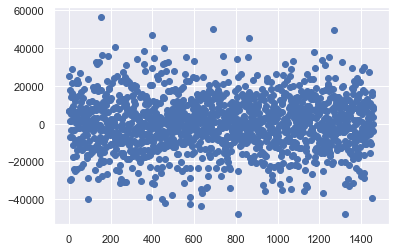

In [198]:
ax = plt.axes()
ax.scatter(y_train.index, residuals)

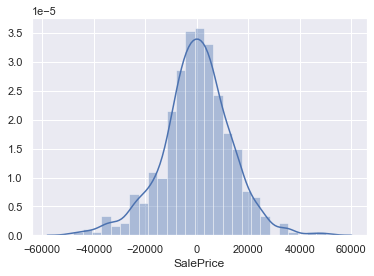

In [199]:
sns.distplot(residuals[500:1000])

In [200]:
print("Skewness: %f" % residuals.skew())
print("Kurtosis: %f" % residuals.kurt())

Skewness: 0.003565
Kurtosis: 0.655485


((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([-48036.82662753, -47906.24354124, -43327.90511743, ...,
          49502.11397364,  50017.52854807,  56546.22391532])),
 (14101.74637438888, 2.1961410296664875e-12, 0.997386381274363))

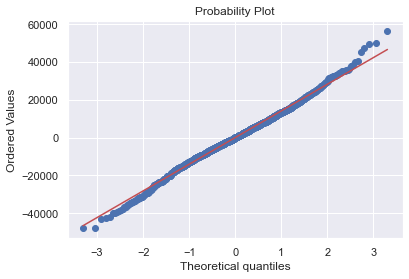

In [201]:
stats.probplot(residuals, plot=plt)

In [202]:
from scipy.stats import normaltest
statistics, pvalue = normaltest(residuals)
print("statistics=%.3f, pvalue=%.3f\n" % (statistics, pvalue))
if p > 0.05:
    print("Probably Gaussian distribution")
else:
    print("Probably not Gaussian distribution")

statistics=16.010, pvalue=0.000

Probably not Gaussian distribution


In [203]:
from scipy.stats import kstest
statistics, pvalue = kstest(residuals, "norm")
print("statistic=%.3f, pvalue=%.3f\n" % (statistics, pvalue))
if pvalue > 0.05:
    print("Probably Gaussian distribution")
else:
    print("Probably not Gaussian distribution")

statistic=0.501, pvalue=0.000

Probably not Gaussian distribution


Basing on data I reject H0 

### 7) Suggestions for next steps in analyzing this data

* Numerous variables computed during Feature Engineering process have been exhibiting strong correlation between each other. Following Feature Selection solutions have to be applied to deal with an issue of multicolinarity:  
    * Variance Threshold
    * Univariate feature selection
    * Variance Inflation Factor

* A paragraph that summarizes the quality of this data set and a request for additional data if needed

Missing values of Ames Housing data are providing additional challenge into process of data sanitazation.  
Moreover, since training data set is rather little the process of fitting the model on such set most likely will result with a "data leakage".
In compare to characteristics of train set the cardinality of characteristcs from test data set can simply prove to be diffrent. Hence deriving predictions will not be possible without recalibration of a model.  
Since descriptive variables of business nature are often expressing strong interpretability of a Target it is strongly adviced to increase sample of provided data set.  
Better models are providing better predictions and smarter decisions. Smarter decissions are either providing us with a larger pofits and/or savings.

# Supervised Learning: Regression

### 1) Main objective of the analysis that specifies whether your model will be focused on prediction or interpretation.

### 2) Brief description of the data set you chose and a summary of its attributes.

### 3) Brief summary of data exploration and actions taken for data cleaning and feature engineering.

### 4) Summary of training at least three linear regression models which should be variations that cover using a simple linear regression as a baseline, adding polynomial effects, and using a regularization regression. Preferably, all use the same training and test splits, or the same cross-validation method.

### 5) A paragraph explaining which of your regressions you recommend as a final model that best fits your needs in terms of accuracy and explainability.

### 6) Summary Key Findings and Insights, which walks your reader through the main drivers of your model and insights from your data derived from your linear regression model.

### 7) Suggestions for next steps in analyzing this data, which may include suggesting revisiting this model adding specific data features to achieve a better explanation or a better prediction.